In [ ]:
!pip install yfinance
!pip install ta
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=ddad015c83df4a7b0a275beb8b327a3e1fc5eeb2c1a9952e1f31437c73b01259
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# required libraries
import json
import requests
import pandas as pd
from datetime import date, timedelta
import collections
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pickle
import time
import pytz
import datetime
import torch
import sklearn.feature_extraction
import sklearn.model_selection
import random
from sklearn.metrics import accuracy_score 
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import ta
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Set the time period 
# Time period of 10 years (2013-2023)
specific_date = pd.to_datetime('2013-01-01')
specific_date_time = date(2013, 1, 1)
specific_end_date = pd.to_datetime('2023-01-01')
start_date = date(2012, 11, 1)
end_date = date(2023, 1, 10) 
delta = date(2023, 1, 1) - specific_date_time

[*********************100%***********************]  1 of 1 completed


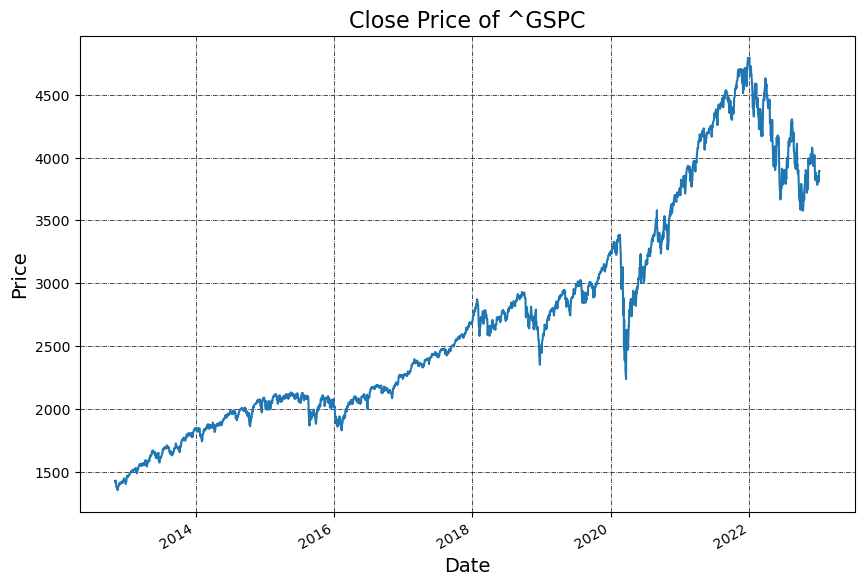

In [5]:
# Get the data for the Stock/Index (this case for the S&P 500 ticker '^GSPC')
ticker = '^GSPC'  
stock_data = yf.download(ticker, start_date, end_date)
stock_data['daily_returns'] =  ((stock_data['Close'] - stock_data['Open']) / stock_data['Open']) * 100

# Plot the Close price
stock_data['Close'].plot(figsize=(10, 7))

plt.title("Close Price of {}".format(ticker), fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

# Show the plot
plt.show()

In [6]:
# Pre-processing the data
# Arrange the dataset to get the Daily Returns
stock_daily_returns = ((stock_data['Close'] - stock_data['Open']) / stock_data['Open']) * 100
stock_returns = pd.DataFrame(stock_daily_returns)
stock_returns.columns = ['Return']
stock_returns = stock_returns.reset_index()

# Days where the stock market is open
tradingDays = pd.DataFrame(stock_returns['Date']).astype(str)
# Arrange index
stock_data["Date"] = stock_data.index
stock_data.reset_index(drop=True, inplace=True)

# get list of trading days so we can use .index()
listOfTradingDays = tradingDays.values.tolist()

In [7]:
# Helper functions to build the dataset

# Function to get 1-day's stock performance
def get1DayReturn(date):
    dayReturn = stock_returns.where(stock_returns['Date'] == date)
    dayReturn = dayReturn.dropna()
    return dayReturn['Return'].iloc[0]

# Function to get tommo's open
def getTommoOpen(date):
    indexOfTommoDay = listOfTradingDays.index([date]) + 1
    if indexOfTommoDay >= len(listOfTradingDays):
        return -1
    date2 = listOfTradingDays[indexOfTommoDay][0]
    return stock_data['Open'].where(stock_data['Date'] == date2).dropna().iloc[0]

# Function to get stock direction from Open - > Close of day n
def getStockDirection(date, n_day):
    dayOpen = getTommoOpen(date)
    indexOfDay = listOfTradingDays.index([date]) + n_day
    
    if indexOfDay >= len(listOfTradingDays):
        return -1
    
    dateClose = listOfTradingDays[indexOfDay][0]
    dayClose = stock_data['Adj Close'].where(stock_data['Date'] == dateClose).dropna().iloc[0]
    if dayClose >= dayOpen: # if close > open then return 1 'Up' 
        return 1
    else: 
        return 0

In [8]:
# Building the Stock prices Dataset
Stock_info = pd.DataFrame({'Today return' : [], 'Tommo_Open' : [], 'Tommo_Direction' : [], '2Day_Direction' : [], '3Day_Direction' : [], '4Day_Direction' : [], '5Day_Direction' : []})
for d in stock_data['Date']:
    Date = d
    date_s = str(d)[0:10]
    new_row = {'Today return': get1DayReturn(d), 'Tommo_Open' : getTommoOpen(date_s) , 'Tommo_Direction': getStockDirection(date_s, 1),'2Day_Direction' : getStockDirection(date_s, 2), '3Day_Direction': getStockDirection(date_s, 3),'4Day_Direction' : getStockDirection(date_s, 4), '5Day_Direction':getStockDirection(date_s, 5)}
    Stock_info = Stock_info.append(new_row, ignore_index=True)

In [9]:
# add this data to the stock_data dataframe
stock_data.drop(columns='daily_returns', inplace=True)
stock_data = pd.merge(stock_data, Stock_info, left_index=True, right_index=True)
stock_data

,Open,High,Low,Close,Adj Close,Volume,Date,Today return,Tommo_Open,Tommo_Direction,2Day_Direction,3Day_Direction,4Day_Direction,5Day_Direction
0,1412.199951,1428.349976,1412.199951,1427.589966,1427.589966,3929890000,2012-11-01,1.089790,1427.589966,0.0,0.0,1.0,0.0,0.0
1,1427.589966,1434.270020,1412.910034,1414.199951,1414.199951,3732480000,2012-11-02,-0.937945,1414.020020,1.0,1.0,0.0,0.0,0.0
2,1414.020020,1419.900024,1408.130005,1417.260010,1417.260010,2921040000,2012-11-05,0.229133,1417.260010,1.0,0.0,0.0,0.0,0.0
3,1417.260010,1433.380005,1417.260010,1428.390015,1428.390015,3306970000,2012-11-06,0.785318,1428.270020,0.0,0.0,0.0,0.0,0.0
4,1428.270020,1428.270020,1388.140015,1394.530029,1394.530029,4356490000,2012-11-07,-2.362298,1394.530029,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559,3853.290039,3878.459961,3794.330078,3824.139893,3824.139893,3959140000,2023-01-03,-0.756500,3840.360107,1.0,0.0,1.0,1.0,-1.0
2560,3840.360107,3873.159912,3815.770020,3852.969971,3852.969971,4414080000,2023-01-04,0.328351,3839.739990,0.0,1.0,1.0,-1.0,-1.0
2561,3839.739990,3839.739990,3802.419922,3808.100098,3808.100098,3893450000,2023-01-05,-0.824011,3823.370117,1.0,1.0,-1.0,-1.0,-1.0
2562,3823.370117,3906.189941,3809.560059,3895.080078,3895.080078,3923560000,2023-01-06,1.875569,3910.820068,0.0,-1.0,-1.0,-1.0,-1.0


In [10]:
# Technical indicator part: Compute and add chosen technical indicators uisng ta library
# Technical indicators similar to Mehar Vijh et al. Paper

# High - Low
stock_data['high-low'] = stock_data['High'] - stock_data['Low']

# Open - Close
stock_data['open-close'] = stock_data['Open'] - stock_data['Close']

# Simple moving average
stock_data['sma_7'] = ta.trend.sma_indicator(close=stock_data['Close'], window=7)
stock_data['sma_14'] = ta.trend.sma_indicator(close=stock_data['Close'], window=14)
stock_data['sma_21'] = ta.trend.sma_indicator(close=stock_data['Close'], window=21)

# Standard Deviation
stock_data['std'] = ta.volatility.bollinger_mavg(stock_data['Close'], window=7)

In [11]:
# Technical indicators similar to Osman Hegazy et al.

# RSI (Relative Strength Index)
stock_data['rsi_7'] = ta.momentum.RSIIndicator(stock_data['Close'], 7).rsi()

# Money Flow Index (MFI)
stock_data['mfi_7'] = ta.volume.money_flow_index(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], volume=stock_data['Volume'], window=7)

# Exponential Moving Average (EMA)
stock_data['ema_7'] = ta.trend.ema_indicator(close=stock_data['Close'], window=7)

# Stochastic Oscillator (SO)
stoch = ta.momentum.StochasticOscillator(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'])
stock_data['so_%K'] = stoch.stoch()
stock_data['so_%D'] = stoch.stoch_signal()

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=stock_data['Close'])
stock_data['macd'] = macd.macd()

In [12]:
# Technical indicators similar to Sanbo Wang (best found technical model)
stock_data['sma'] = ta.trend.sma_indicator(close=stock_data['Close'], window=10)


# Bollinger Bands (BBANDS), use the average.
bb = ta.volatility.BollingerBands(close=stock_data['Close'], window=20, window_dev=2)
stock_data['bb_middleband'] = bb.bollinger_mavg()

# AROON
ind = ta.trend.AroonIndicator(close =stock_data['Close'], window=25)
stock_data['ar_up'] =  ind.aroon_up() 
stock_data['ar_down'] = ind.aroon_down()

# Commodity Channel Index (CCI)
stock_data['cci'] = ta.trend.CCIIndicator(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], window=10).cci()

# Chande Momentum Oscillator (CMO) (calculating it manually since, library ta does not have it)
# Set the period and calculate the difference between the current price and the price 10 periods ago
price_diff = stock_data['Close'] - stock_data['Close'].shift(10)
gain = np.where(price_diff > 0, price_diff, 0)
gain_sum = pd.Series(gain).rolling(window=10).sum()
loss = np.where(price_diff < 0, abs(price_diff), 0)
loss_sum = pd.Series(loss).rolling(window=10).sum()
stock_data['cmo'] = ((gain_sum - loss_sum) / (gain_sum + loss_sum)).fillna(0)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=stock_data['Close'])
stock_data['macd'] = macd.macd()

# RSI (Relative Strength Index)
stock_data['rsi'] = ta.momentum.RSIIndicator(stock_data['Close'], 10).rsi()

# Stochastic Oscillator (SO)
stoch = ta.momentum.StochasticOscillator(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'])
stock_data['so_%K'] = stoch.stoch()
stock_data['so_%D'] = stoch.stoch_signal()

# Williams %R (WILLR)
stock_data['willr'] = ta.momentum.WilliamsRIndicator(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], lbp=10).williams_r()

In [13]:
# Technical indicators similar to Taylan Kabban (For Hybrid model)

# RSI (Relative Strength Index)
stock_data['rsi'] = ta.momentum.RSIIndicator(stock_data['Close'], 14).rsi()

# Stochastic Oscillator (SO)
stoch = ta.momentum.StochasticOscillator(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], window=14)
stock_data['%K'] = stoch.stoch()


# Simple moving average
stock_data['sma'] = ta.trend.sma_indicator(close=stock_data['Close'], window=14)

In [14]:
# Pre-processing and cleaning
# Keep the need trading days
stock_data = stock_data[stock_data['Date'] > specific_date]
stock_data = stock_data[stock_data['Date'] < specific_end_date]

# reset index
stock_data = stock_data.reset_index()
del stock_data['index']

# delete last row (since we always predict next day)
stock_data = stock_data.iloc[:-1]

In [16]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Date,Today return,Tommo_Open,Tommo_Direction,...,macd,sma,bb_middleband,ar_up,ar_down,cci,cmo,rsi,willr,%K
0,1426.189941,1462.430054,1426.189941,1462.420044,1462.420044,4202600000,2013-01-02,2.540342,1462.420044,0.0,...,6.376922,1428.852853,1424.933496,100.0,4.0,121.230077,0.639208,64.471728,-0.015562,99.984438
1,1462.420044,1465.469971,1455.530029,1459.369995,1459.369995,3829730000,2013-01-03,-0.208562,1459.369995,1.0,...,8.372865,1431.059283,1427.549493,96.0,88.0,143.976800,0.581270,63.102256,-9.055785,90.944215
2,1459.369995,1467.939941,1458.989990,1466.469971,1466.469971,3424290000,2013-01-04,0.486510,1466.469971,0.0,...,10.407601,1434.417855,1430.408990,100.0,84.0,127.382281,0.591251,64.967721,-2.105072,97.894928
3,1466.469971,1466.469971,1456.619995,1461.890015,1461.890015,3304970000,2013-01-07,-0.312312,1461.890015,0.0,...,11.517809,1437.868574,1432.806494,96.0,80.0,92.233405,0.562057,62.763360,-8.663799,91.336201
4,1461.890015,1461.890015,1451.640015,1457.150024,1457.150024,3601600000,2013-01-08,-0.324237,1457.150024,1.0,...,11.878254,1439.782148,1434.760498,92.0,76.0,60.821371,0.599050,60.476332,-15.451702,84.548298


In [17]:
# remove certain features
final_dataset = stock_data.drop(columns=['Date','Tommo_Direction','2Day_Direction', '3Day_Direction', '4Day_Direction', '5Day_Direction'])

# Using StandardScaler to normalise the values before passing them to the Neural network
scaler = StandardScaler()
normalisedvalues = scaler.fit_transform(final_dataset.values)
normalised_dataset = pd.DataFrame(columns = final_dataset.columns, data = normalisedvalues, index = final_dataset.index)

In [18]:
print("Number of instances: ", len(normalised_dataset)) 

Number of instances:  2517


In [19]:
# News Data from NYT (to be processed using NLP methods) (this part can be skiped)*
# Load news data for period 2013-2023
news_data = pd.read_feather("dataset\\news_data_2013-2023.feather")
news_data

,Date,Headline,Abstract,Source
0,2013-01-01 23:46:43+00:00,New York’s Office Builders Raise Their Online ...,The marketing teams behind New York office bui...,The New York Times
1,2013-01-01 22:35:07+00:00,Bigger Tax Bite for Most Under Fiscal Pact,Although a higher income tax rate will apply o...,The New York Times
2,2013-01-01 22:21:06+00:00,Biotech Players Lead a Boom in Cambridge,"The presence of M.I.T. and Harvard, along with...",The New York Times
3,2013-01-01 19:42:25+00:00,"Malls Blossom in Russia, With a Middle Class",While malls appear to be past their peak in th...,The New York Times
4,2013-01-01 08:29:10+00:00,Duke Seeks Final Approval for Its Campus in China,Duke University aims to submit its application...,International Herald Tribune
...,...,...,...,...
58580,2023-04-28 10:00:31+00:00,The Eurozone Economy Shows Signs of Modest Growth,The countries that use the euro recorded econo...,The New York Times
58581,2023-04-28 09:00:36+00:00,"Hollywood, Both Frantic and Calm, Braces for W...",Studios have moved up deadlines for TV writers...,The New York Times
58582,2023-04-28 09:00:34+00:00,"Higher Food Prices Bring Bigger Profits, but C...",Some of the biggest packaged food companies ra...,The New York Times
58583,2023-04-28 09:00:23+00:00,A ‘Rocky and Bumpy’ Economy Where Wages Are Up...,Key pay and inflation gauges have stayed stubb...,The New York Times


In [20]:
# keep only date and article columns
news_data = news_data.drop(columns=['Source']) # remove Source
# convert date column to pd.datetime
news_data['Date'] = pd.to_datetime(news_data['Date'])

article_dataset = pd.DataFrame({
    'Date': news_data['Date'].dt.date.astype(str),
    'Time': news_data['Date'].dt.time,
    'Headline': news_data['Headline'],
    'Abstract': news_data['Abstract']
})
article_dataset['Text'] = article_dataset['Headline'] + ' ' + article_dataset['Abstract'] # column that we will use

In [21]:
# function to get open and close time of the US stock market according to EDT OR EST
def get_US_market_open_close_time(date):
    eastern_tz = pytz.timezone('US/Eastern')
    naive_date = datetime.datetime.strptime(date, '%Y-%m-%d')
    aware_date = eastern_tz.localize(naive_date, is_dst=None)
    if aware_date.dst() == datetime.timedelta(0):
        # case EST
        open_time = '14:30:00'
        close_time = '21:00:00'
    else:
        # case EDT
        open_time = '13:30:00'
        close_time = '20:00:00'
        
    return open_time, close_time

# get Articles takes two parameters date and mode('b' before market open and 'a' after market open)
# time of articles is in UTC
def getArticles(date, mode):
    open_time, close_time = get_US_market_open_close_time(date)
    news = article_dataset.where(article_dataset['Date'] == date).dropna()
    # convert format (from string to time)
    time2 = datetime.datetime.strptime(open_time, '%H:%M:%S').time()
    if mode == 'b':
        # Get news before Open
        news = news.where(news['Time'] < time2).dropna()
    elif mode == 'a':
        # Get news after close
        news = news.where(news['Time'] > time2).dropna()
        
    if len(news) == 0: # Just in Case
        return ''

    return ' '.join(news["Text"])

In [22]:
# Building the training Dataset
# Sorting the news articles according to Market days
# Group articles of the same day together, a day is defined as the time between market close and next market open

TrainingSet = pd.DataFrame({'Date' : [], 'NewsHeadlines' : []})
data = ''
for i in range(delta.days + 1):
    day = specific_date_time + timedelta(days=i)
    day = str(day)
    
    if day in tradingDays['Date'].values:
        data += getArticles(day, 'b')
        new_row = {'Date': day, 'NewsHeadlines': data}
        TrainingSet = TrainingSet.append(new_row, ignore_index=True)
        data = ''
        data += getArticles(day,'a')
    else:
        data += getArticles(day,'s')
        
TrainingSet

,Date,NewsHeadlines
0,2013-01-02,New York’s Office Builders Raise Their Online ...
1,2013-01-03,A Gigantic Sigh of Relief as Tax Uncertainty E...
2,2013-01-04,Rig Owner Will Settle With U.S. in Gulf Spill ...
3,2013-01-07,Europe Likely to Be Harder on Google Over Sear...
4,2013-01-08,Avis and Hertz Acquisitions Raise Questions Ov...
...,...,...
2513,2022-12-23,Twitter Is Said to Have Struggled Over Reveali...
2514,2022-12-27,Alameda Executive Says She Is ‘Truly Sorry’ fo...
2515,2022-12-28,Thousands Will Live Here One Day (as Long as T...
2516,2022-12-29,"10 Months Into Job, Southwest’s C.E.O. Faces a..."


In [ ]:
# NLP Method: TF-Idf
# Tokenise every element in the text
text_tokens = []
tokenizer = RegexpTokenizer(r'\w+') # to not include punctuation
for text in TrainingSet['NewsHeadlines']:
    text_tokens.append(tokenizer.tokenize(text))

# Case-Folding and Stop Word removal and Stemming for every word
stop_words = stopwords.words('english')
stop_words.extend(['said', 'b', '000']) # add other stopwords
ps = PorterStemmer()

for i in range(len(text_tokens)):
    text_tokens[i] = [ps.stem(word.casefold()) for word in text_tokens[i] if word.casefold() not in stop_words]

# Find vocabulary - unique terms
vocab = list(set(word for text in text_tokens for word in text))

# Get count for every term in every doc and normalise this term frequency by dividing with max term frequency in specific day's text
rows = len(text_tokens) # articles
col = len(vocab) # words
tf = np.zeros((rows, col))
for i in range(len(text_tokens)):
    max_tf = max(text_tokens[i].count(word) for word in text_tokens[i])
    for j in range(col):
        tf[i][j] = text_tokens[i].count(vocab[j]) / max_tf

# Find the DF for every term in vocabulary and if DF is less than n, remove term
N = len(tf)
df = np.zeros(col)
to_remove = []
for j in range(col):
    df[j] = sum(tf[i][j] > 0 for i in range(rows))
    if df[j] < 200:
        to_remove.append(j)

for j in reversed(to_remove):
    vocab.pop(j)
    tf = np.delete(tf, j, axis=1)
    df = np.delete(df, j)
        
# Calculate IDF using last n days
dayLookBack = 5 # looking back 5 trading days
idf = np.zeros((rows, len(vocab)))

for row, col in enumerate(idf):
    for idx in range(0, len(col)):
        df_lookback = sum(tf[i][idx] > 0 for i in range(max(0, row - dayLookBack), row+1))
        if df_lookback > 0:
            idf[row][idx] = np.log(dayLookBack / df_lookback) 
            # else leave it 0

# Calculate TF-IDF
tf_idf = np.multiply(tf, idf)
# normalize the TF-IDF matrix using L2 normalization
tf_idf = normalize(tf_idf, norm='l2', axis=1)

# Print the TF-IDF matrix
print(tf_idf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# NLP Method: GloVe (Global Vectors for Word Representation) 

# Load the small English model in spaCy
nlp = spacy.load('en_core_web_sm')

# Find the length of the longest vector (every vector must have same length)
max_len = 0
for text in TrainingSet['NewsHeadlines']:
    doc = nlp(text)
    if len(doc) > max_len:
        max_len = len(doc)

# Create an empty list to store the GloVe vectors
glove_vectors = []

# Iterate over each text in the NewsHeadlines column
for text in TrainingSet['NewsHeadlines']:
    # Tokenize the text using spaCy
    doc = nlp(text)
    
    # Get the GloVe vector for each token
    token_vectors = [token.vector for token in doc]
    
    # Pad the vectors to the maximum length
    if len(token_vectors) < max_len:
        token_vectors += [np.zeros_like(token_vectors[0])] * (max_len - len(token_vectors))
    
    # Get the average GloVe vector for the text
    text_vector = np.mean(token_vectors, axis=0)
    
    # Add the text vector to the list of vectors
    glove_vectors.append(text_vector)

In [ ]:
# Alternative to NLP representations: getting sentiment score using VADER (Valence Aware Dictionary and sEntiment Reasoner),
sia = SentimentIntensityAnalyzer()
sentiment_scores = []
# Get the sentiment values for each headline
for text in TrainingSet['NewsHeadlines']:
    sentiment = sia.polarity_scores(text)
    sentiment_scores.append(sentiment['compound'])

In [ ]:
# Vector representation and Sentiment scores for news article
News_dataset = pd.DataFrame({
    'Date': TrainingSet['Date'].astype(str),
    'tf_idf': tf_idf.tolist(),
    'glove' : glove_vectors,
    'sentiment scores': sentiment_scores
})

In [ ]:
# Save info
# Save News_dataset
# News_dataset.to_feather('OldTrain.feather')
# Save Vocab
# with open('vocab.pkl', 'wb') as f:
#    pickle.dump(vocab, f)

In [26]:
# load the news data (** cell to load all the preprocessed news data)
# Load News_dataset
News_dataset = pd.read_feather("preprocessed_datasets/Train_2020-2023.feather")

# Load Vocab
with open('preprocessed_datasets/vocab_df_3.pkl', 'rb') as f:
    vocab_df_3 = pickle.load(f)

with open('preprocessed_datasets/vocab_df_50.pkl', 'rb') as f:
    vocab_df_50 = pickle.load(f)

with open('preprocessed_datasets/vocab_df_100.pkl', 'rb') as f:
    vocab_df_100 = pickle.load(f)

with open('preprocessed_datasets/vocab_df_200.pkl', 'rb') as f:
    vocab_df_200 = pickle.load(f)

with open('preprocessed_datasets/vocab_sentiment_dict.pkl', 'rb') as f:
    vocab_sentiment_dict = pickle.load(f)

In [28]:
# remove the first day of news data since we do not need it (we always predict from tommo open -> close)
News_dataset = News_dataset.drop(index=0)
# arrange index
News_dataset = News_dataset.reset_index()
del News_dataset['index']
News_dataset.head()

,Date,tf_idf,glove,sentiment scores,tf_idf_common_50,tf_idf_common_100,tf_idf_custom_sentiment,tf_idf_common_200
0,2013-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0065032337, -0.026966467, -0.010776335, 0.0...",0.9941,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.06365168830912431,...","[0.0, 0.0, 0.06754302064687229, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07219226694801421,..."
1,2013-01-04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.008706812, -0.031403296, -0.021160785, 0.00...",0.9556,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.035472046521935446, 0.062305...","[0.0, 0.0558712519146814, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2013-01-07,"[0.0, 0.03853083814037951, 0.0, 0.0, 0.0, 0.0,...","[0.0030595479, -0.050828382, -0.03941388, 0.04...",0.9881,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.023406448620545438, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.04431067049561818, 0.0, 0.0, 0.02..."
3,2013-01-08,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0090215495, -0.017810782, -0.011544912, 0.0...",0.8466,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.07137878093524182, 0.0, 0.0, 0.0,..."
4,2013-01-09,"[0.0, 0.035378497414749396, 0.0, 0.0, 0.0, 0.0...","[0.0021759986, -0.045274474, -0.022185955, 0.0...",-0.9296,"[0.0, 0.0, 0.0, 0.0, 0.06773414184281647, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.023177936839543795, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.08393975665850119, 0.0, 0.0, 0.083939756658..."


In [29]:
# Choose NLP representation
# News_dataset['News Vector'] = News_dataset['tf_idf'] # df > 3
# News_dataset['News Vector'] = News_dataset['glove']
# News_dataset['News Vector'] = News_dataset['tf_idf_common_50']
# News_dataset['News Vector'] = News_dataset['tf_idf_common_100']
News_dataset['News Vector'] = News_dataset['tf_idf_common_200']
# News_dataset['News Vector'] = News_dataset['tf_idf_custom_sentiment']

In [46]:
def Get_Keywords(date, vocab):
    # get news vector for the given date
    vector = np.array(News_dataset.loc[News_dataset['Date'] == date]['News Vector'].iloc[0].copy())
    top_terms = []
    i = 0
    # get top 10 terms from news vector
    while len(top_terms) < 10:
        max_index = vector.argmax()
        if vector[max_index] == 0:
            return top_terms
        term = vocab[max_index]
        if term not in top_terms:
            top_terms.append(term)
        vector[max_index] = -1
        i = i + 1
    print('The top 10 terms are', top_terms)
    return top_terms

Get_Keywords('2022-12-01', vocab_df_200)

The top 10 terms are ['reserv', 'watch', 'feder', 'dealbook', 'increas', 'panel', 'island', 'though', 'huge', 'appear']


['reserv',
 'watch',
 'feder',
 'dealbook',
 'increas',
 'panel',
 'island',
 'though',
 'huge',
 'appear']

In [45]:
print('\n'.join(TrainingSet[TrainingSet['Date'] == '2022-12-01']['NewsHeadlines']))

Sam Bankman-Fried Blames ‘Huge Management Failures’ for FTX Collapse Mr. Bankman-Fried spoke at The New York Times’s DealBook conference, in his first public appearance since his crypto exchange imploded. FTX’s Sister Firm, Alameda Research, Was Central to Collapse The relationship between Alameda and FTX — and how the two propped each other up — is coming under scrutiny as prosecutors and regulators investigate the exchange’s collapse. Watch live as Sam Bankman-Fried speaks with DealBook. Sam Bankman-Fried, the founder of the collapsed cryptocurrency exchange FTX, is set to speak to Andrew Ross Sorkin at 5 p.m. Eastern time at the DealBook Summit. You can watch it here and follow along with live analysis by our reporters. Epstein Estate Agrees to Pay More Than $105 Million to U.S. Virgin Islands The estate of the disgraced financier Jeffrey Epstein will repay tax benefits and half the proceeds from the sale of an island he owned. Mark Zuckerberg defends company’s push into the metaver

In [47]:
NewsVectors = pd.DataFrame(News_dataset['News Vector'].values.tolist())
NewsVectors.columns = NewsVectors.columns.astype(str)
NewsVectors.head()

,0,1,2,3,4,5,6,7,8,9,...,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065
0,0.00000,0.0,0.000000,0.00000,0.0,0.072192,0.000000,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.072192,0.000000,0.0,0.000000,0.0,0.000000
1,0.00000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.038710,0.000000,0.0,0.067994,0.0,0.000000
2,0.00000,0.0,0.044311,0.00000,0.0,0.025227,0.044311,0.0,0.0,0.044311,...,0.000000,0.00000,0.0,0.0,0.014064,0.025227,0.0,0.000000,0.0,0.044311
3,0.00000,0.0,0.071379,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.125375,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.08394,0.0,0.000000,0.08394,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.08394,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [48]:
# combine NewsVectors with technical indicators
stock_dataset = normalised_dataset.join(NewsVectors).drop(columns=['Open','Adj Close'])
stock_dataset['Today return'] = stock_dataset['Today return'].apply(lambda x: 0 if x < 0 else 1) # convert column to either 0 or 1

In [52]:
# Options
# 1) Using both news and technical indicators
training_dataset = stock_dataset.drop(columns=['High','Low','Close','Volume','Today return'])

In [53]:
# 2) Using just technical indicators
training_dataset = normalised_dataset.drop(columns=['High','Low','Close','Adj Close', 'Open','Volume','Today return'])

In [54]:
# 3) Using just news vector
training_dataset = NewsVectors

In [ ]:
# 4) Add sentiment scores
training_dataset['sentiment scores'] = News_dataset['sentiment scores']

In [55]:
# Get the date again
training_dataset['Date'] = pd.to_datetime(News_dataset['Date']) # we are predicting from this trading day's open -> (example close if Tommo_Direction)

# Get label also
training_dataset['Label'] = stock_data['Tommo_Direction'] # if we predicting tommo direction
#training_dataset['Label'] = stock_data['3Day_Direction'] # if we predicting next 3 Day Direction
#training_dataset['Label'] = stock_data['5Day_Direction'] # if we predicting 5 Day Direction

In [56]:
training_dataset

,0,1,2,3,4,5,6,7,8,9,...,1058,1059,1060,1061,1062,1063,1064,1065,Date,Label
0,0.00000,0.000000,0.000000,0.00000,0.0,0.072192,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.072192,0.000000,0.0,0.000000,0.0,0.000000,2013-01-03,0.0
1,0.00000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.038710,0.000000,0.0,0.067994,0.0,0.000000,2013-01-04,1.0
2,0.00000,0.000000,0.044311,0.00000,0.0,0.025227,0.044311,0.0,0.0,0.044311,...,0.000000,0.0,0.014064,0.025227,0.0,0.000000,0.0,0.044311,2013-01-07,0.0
3,0.00000,0.000000,0.071379,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2013-01-08,0.0
4,0.08394,0.000000,0.000000,0.08394,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2013-01-09,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,0.00000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.052939,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2022-12-23,1.0
2513,0.00000,0.081422,0.000000,0.00000,0.0,0.081422,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.092710,2022-12-27,0.0
2514,0.00000,0.000000,0.000000,0.00000,0.0,0.109728,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2022-12-28,0.0
2515,0.00000,0.081818,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2022-12-29,1.0


In [57]:
# Split this training set into train (and validation) and test sets according to date
Train_Test_Sets = []
# Create a list of the train-test split dates
train_test_splits = [
          ('2013-01-01', '2019-12-31', '2020-01-01', '2020-12-31'),
          ('2013-01-01', '2020-12-31', '2021-01-01', '2021-12-31'),
          ('2013-01-01', '2021-12-31', '2022-01-01', '2022-12-31'),]

# Loop over the list of splits and create the corresponding train and test sets
for i, (train_start, train_end, test_start, test_end) in enumerate(train_test_splits):
    train_set = training_dataset[(training_dataset['Date'] >= train_start) & (training_dataset['Date'] <= train_end)].drop(columns=['Date'])
    test_set = training_dataset[(training_dataset['Date'] >= test_start) & (training_dataset['Date'] <= test_end)].drop(columns=['Date'])
    Train_Test_Sets.append((train_set,test_set))

In [58]:
# Tensors containing all train data to get hyper-parameters for models
x_Train_set = Train_Test_Sets[0][0].drop(columns=['Label'])
y_Train_set = Train_Test_Sets[0][0]['Label']
X_tensor = torch.tensor(x_Train_set.values, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y_Train_set.to_numpy(), dtype=torch.float32, device=device)
input_size = len(X_tensor[0])

# use k-fold validation to check model accuracy
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

In [59]:
# Artificial Neural Network
class ANN(torch.nn.Module):
    def __init__(self, input_layer, hidden_layer, dropout):
        super().__init__()

        self.Leakyrelu = torch.nn.LeakyReLU(0.1)
        self.dropout = torch.nn.Dropout(dropout)

        # Add dense layers
        self.fc_0 = torch.nn.Linear(input_layer, hidden_layer) # input layer
        self.fc_1 = torch.nn.Linear(hidden_layer, hidden_layer)
        self.fc_2 = torch.nn.Linear(hidden_layer, hidden_layer)
        self.fc_3 = torch.nn.Linear(hidden_layer, 1) # output layer

    def forward(self, x):

        # Perform the fc layers
        
        x = self.Leakyrelu(self.fc_0(x))
        x = self.dropout(x)
        x = self.Leakyrelu(self.fc_1(x))
        x = self.Leakyrelu(self.fc_2(x))
        x = self.fc_3(x)

        return x

# function to help train model on data split
def train_model_on_split_ann(X_train, y_train, X_val, y_val, hyperparams):
    # build the NN with these given params
    (learning_rate, epoch, dropout, hidden_layer) = hyperparams
    # Instantiate the model
    model_ANN = ANN(len(X_train[0]), hidden_layer, dropout)
    model_ANN = model_ANN.to(device)
    # Define the optimizer
    optimiser = torch.optim.Adam(model_ANN.parameters(), lr=learning_rate)

    # train the split
    best_val_acc = 0.00
    for step in range(1, epoch+1):
        output = model_ANN(X_train)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y_train.unsqueeze(1))

        # Backward pass
        optimiser.zero_grad()
        error.backward()
        optimiser.step()

        # Get Accuracy on validation set (if training acc > 0.5)
        with torch.no_grad():
            # validation set
            predictions = torch.round(torch.sigmoid(model_ANN(X_train)))[:, 0].detach().cpu().numpy()
            if not np.isnan(predictions).any():
                train_acc = accuracy_score(y_train.cpu(), predictions)
            else:
                train_acc = 0

            if train_acc > 0.5:
                #  get validation accuracy
                predictions = torch.round(torch.sigmoid(model_ANN(X_val)))[:, 0].detach().cpu().numpy()
                val_acc = accuracy_score(y_val.cpu(), predictions)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                # if train acc is above 99% end training
                if train_acc > 0.99:
                    return best_val_acc
    return best_val_acc

In [60]:
# Gated Recurrent Unit (GRU)
class GRU_Neural_Network(torch.nn.Module):
    def __init__(self, input_layer, hidden_layer_1, hidden_layer_2, dropout, num_layers):
        super().__init__()

        self.Leakyrelu = torch.nn.LeakyReLU(0.1)
        self.dropout_1 = torch.nn.Dropout(dropout)

        # Add a dense layer 
        self.fc_0 = torch.nn.Linear(input_layer, hidden_layer_1)

        # GRU layers
        self.gru_1 = torch.nn.GRU(hidden_layer_1, hidden_layer_2, num_layers, batch_first=True)

        # Add a dense layer
        self.fc_1 = torch.nn.Linear(hidden_layer_2, 1)

    def forward(self, x):
        # Pass to the fc layer
        x = self.Leakyrelu(self.fc_0(x))
        x = self.dropout_1(x)
        # Pass to the gru cell
        x , _ = self.gru_1(x)
        x = x[:, -1, :]
        x = self.fc_1(x)
        return x

In [61]:
class LSTM_Neural_Network(torch.nn.Module):
    def __init__(self, input_layer, hidden_layer_1, hidden_layer_2, dropout, num_layers):
        super().__init__()

        self.Leakyrelu = torch.nn.LeakyReLU(0.1)
        self.dropout_1 = torch.nn.Dropout(dropout)

        # Add a dense layer 
        self.fc_0 = torch.nn.Linear(input_layer, hidden_layer_1)

        # LSTM layers
        self.lstm_1 = torch.nn.LSTM(hidden_layer_1, hidden_layer_2, num_layers, batch_first=True)

        # Add a dense layer
        self.fc_1 = torch.nn.Linear(hidden_layer_2, 1)

    def forward(self, x):
        # Pass to the fc layer
        x = self.Leakyrelu(self.fc_0(x))
        x = self.dropout_1(x)
        # Pass to the lstm cell
        x , _ = self.lstm_1(x)
        x = x[:, -1, :]
        x = self.fc_1(x)
        return x

In [62]:
# function to train model on data split and return best validation accuracy
def train_model_on_split_gru_or_lstm(train_dataloader, val_dataloader, hyperparams, input_size, mode):
    # get all train data into inputs and labels tensors
    train_inputs, train_labels = next(iter(train_dataloader))
    for inputs, labels in train_dataloader:
        train_inputs = torch.cat([train_inputs, inputs], dim=0)
        train_labels = torch.cat([train_labels, labels], dim=0)

    # get all validation data into inputs and labels tensors
    val_inputs, val_labels = next(iter(val_dataloader))
    for inputs, labels in val_dataloader:
        val_inputs = torch.cat([val_inputs, inputs], dim=0)
        val_labels = torch.cat([val_labels, labels], dim=0)

    # build the NN with these given params
    (learning_rate, epoch, dropout, hidden_layer_1, hidden_layer_2, num_layers, _, _) = hyperparams

    # Instantiate the model
    if mode == 'GRU':
        model = GRU_Neural_Network(input_size, hidden_layer_1, hidden_layer_2, dropout, num_layers)
        model = model.to(device)
    if mode == 'LSTM':
        model = LSTM_Neural_Network(input_size, hidden_layer_1, hidden_layer_2, dropout, num_layers)
        model = model.to(device)


    # Define the optimiser
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_acc = 0.00

    # train on the split
    # train the model
    for step in range(epoch):
        model.train()
        # train on batches
        for inputs, labels in train_dataloader:
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels.unsqueeze(1))
            loss.backward()
            optimiser.step()
        # check accuracy on train set and validation set

        # Get Accuracy on validation set (if training acc > 0.5)
        with torch.no_grad():
            # validation set
            predictions = torch.round(torch.sigmoid(model(train_inputs)))[:, 0].detach().cpu().numpy()
            if not np.isnan(predictions).any():
                train_acc = accuracy_score(train_labels.cpu(), predictions)
            else:
                train_acc = 0

            if train_acc > 0.5:
                #  get validation accuracy
                predictions = torch.round(torch.sigmoid(model(val_inputs)))[:, 0].detach().cpu().numpy()
                val_acc = accuracy_score(val_labels.cpu(), predictions)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                # if train acc is above 99% end training
                if train_acc > 0.99:
                    return best_val_acc
                  
    return best_val_acc

In [ ]:
# ANN
# Chosing a suitable model : Using random search through parameters and Cross Validation

# Random search through parameters combinations to find a suitable model
learning_rate_set = [0.001, 0.0001, 0.00001]
epoch_set = [500, 750, 1_000]
dropout_set = [0.2, 0.3, 0.4]
hidden_layer_size_set = [64, 128, 256, 400, 500, 750]

already_generated = set ()
best_overall_val_acc = 0.0
best_hyperparams = None

for count in range(1, 15+1):
    found = True
    while found:
        learning_rate = random.choice(learning_rate_set)
        epoch = random.choice(epoch_set)
        dropout = random.choice(dropout_set)
        hidden_layer_size = random.choice(hidden_layer_size_set)

        hyperparams = (learning_rate, epoch, dropout, hidden_layer_size)
        if hyperparams not in already_generated:
            already_generated.add(hyperparams)
            found = False
    
    # Training the model using k-fold validation
    fold_val_accuracy = []
    for fold, (train_index, val_index) in enumerate(tscv.split(X_tensor)):
        X_train, X_val = X_tensor[train_index], X_tensor[val_index]
        y_train, y_val = y_tensor[train_index], y_tensor[val_index]

        score = train_model_on_split_ann(X_train, y_train, X_val, y_val, hyperparams)
        fold_val_accuracy.append(score)

        avg_val_acc = sum(fold_val_accuracy)/len(fold_val_accuracy)
                        
    # check if this param configuration had the best val accuracy
    if avg_val_acc > best_overall_val_acc:
        print(count,"Found better accuracy of",avg_val_acc)
        best_overall_val_acc = avg_val_acc
        best_hyperparams = hyperparams
print("ANN CV average:", best_overall_val_acc)
# Best Params found for ANN
(learning_rate_ann, epoch_ann, dropout_ann, hidden_layer_ann) = best_hyperparams
print('Best Params, For ANN:')
print('learning_rate:', learning_rate_ann)
print('epoch:', epoch_ann)
print('dropout:', dropout_ann) 
print('hidden_layer_size:', hidden_layer_ann)

1 Found better accuracy of 0.551875
3 Found better accuracy of 0.580625
8 Found better accuracy of 0.5831249999999999
9 Found better accuracy of 0.583125
14 Found better accuracy of 0.588125
ANN CV average: 0.588125
Best Params, For ANN:
learning_rate: 1e-05
epoch: 500
dropout: 0.3
hidden_layer_size: 750


In [84]:
(learning_rate_ann, epoch_ann, dropout_ann, hidden_layer_ann) = (0.0001, 750, 0.4, 64)

In [ ]:
# GRU
# Chosing a suitable model : Using random search through parameters and Cross Validation
# Random search through parameters combinations to find a suitable model
learning_rate_set = [0.001, 0.0001, 0.00001, 0.000001]
epoch_set = [500, 750, 1_000]
dropout_set = [0.2, 0.3, 0.4]
hidden_layer_size_1_set = [32, 64, 128, 256, 400, 500, 750]
hidden_layer_size_2_set = [32, 64, 128, 256, 400, 500, 750]
num_layers_set = [1, 2, 3]
batch_size_set = [16, 32, 64, 128, 256]
gnn_look_back_set = [1, 3, 5, 10, 15]

already_generated = set()
best_overall_val_acc = 0.0
best_hyperparams = None

for count in range(1, 15+1):
    found = True
    while found:
        learning_rate = random.choice(learning_rate_set)
        epoch = random.choice(epoch_set)
        dropout = random.choice(dropout_set)
        hidden_layer_1 = random.choice(hidden_layer_size_1_set)
        hidden_layer_2 = random.choice(hidden_layer_size_2_set)
        num_layer = random.choice(num_layers_set)
        batch_size = random.choice(batch_size_set)
        look_back = random.choice(gnn_look_back_set)
        hyperparams = (learning_rate, epoch, dropout, hidden_layer_1, hidden_layer_2, num_layer, batch_size, look_back)
        if hyperparams not in already_generated:
            already_generated.add(hyperparams)
            found = False
    
    # Training the model using k-fold validation
    fold_val_accuracy = []
    for fold, (train_index, val_index) in enumerate(tscv.split(X_tensor)):
        X_train, X_val = X_tensor[train_index], X_tensor[val_index]
        y_train, y_val = y_tensor[train_index], y_tensor[val_index]
        # preprocess the data and convert them to dataloaders

        # define the sequence length (how many days to use as input to the model)
        seq_length = look_back

        # create a sliding window view of the data for sequences of length seq_length
        train_seq = [X_train[i:i+seq_length] for i in range(len(X_train) - seq_length)]
        val_seq = [X_val[i:i+seq_length] for i in range(len(X_val) - seq_length)]

        # convert to PyTorch tensors
        train_seq = torch.stack(train_seq)
        val_seq = torch.stack(val_seq)

        # create PyTorch dataset and data loader
        train_dataset = TensorDataset(train_seq, y_train[seq_length:])
        val_dataset = TensorDataset(val_seq, y_val[seq_length:])

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        score = train_model_on_split_gru_or_lstm(train_dataloader, val_dataloader, hyperparams, input_size, 'GRU')
        fold_val_accuracy.append(score)

        avg_val_acc = sum(fold_val_accuracy)/len(fold_val_accuracy)
             
    # check if this param configuration had the best val accuracy
    if avg_val_acc > best_overall_val_acc:
        print(count,"Found better accuracy of",avg_val_acc)
        best_overall_val_acc = avg_val_acc
        best_hyperparams = hyperparams

print("GRU CV average:", best_overall_val_acc)
# Best Params found for GRU
(learning_rate_gru, epoch_gru, dropout_gru, hidden_layer_1_gru, hidden_layer_2_gru, num_layer_gru, batch_size_gru, look_back_gru) = best_hyperparams
print('Best Params:')
print('learning_rate:', learning_rate_gru)
print('epoch:', epoch_gru)
print('dropout:', dropout_gru) 
print('hidden_layer_size_1:', hidden_layer_1_gru)
print('hidden_layer_size_2:', hidden_layer_2_gru)
print('num_layer_gru', num_layer_gru)
print('batch_size_gru', batch_size_gru)
print('look_back_gru', look_back_gru)

GRU CV average: 0.5695652173913043
Best Params:
learning_rate: 1e-05
epoch: 1000
dropout: 0.3
hidden_layer_size_1: 500
hidden_layer_size_2: 64
num_layer_gru 2
batch_size_gru 16
look_back_gru 15


In [83]:
(learning_rate_gru, epoch_gru, dropout_gru, hidden_layer_1_gru, hidden_layer_2_gru, num_layer_gru, batch_size_gru, look_back_gru) = (1e-05, 500, 0.4, 64, 500, 2, 64, 3)

In [ ]:
# LSTM
# Chosing a suitable model : Using random search through parameters and Cross Validation
# Random search through parameters combinations to find a suitable model
learning_rate_set = [0.001, 0.0001, 0.00001, 0.000001]
epoch_set = [500, 750, 1_000]
dropout_set = [0.2, 0.3, 0.4]
hidden_layer_size_1_set = [32, 64, 128, 256, 400, 500, 750]
hidden_layer_size_2_set = [32, 64, 128, 256, 400, 500, 750]
num_layers_set = [1,2,3]
batch_size_set = [16, 32, 64, 128, 256]
lstm_look_back_set = [1, 3, 5, 10, 15]

already_generated = set()
best_overall_val_acc = 0.0
best_hyperparams = None

for count in range(1, 15+1):
    found = True
    while found:
        learning_rate = random.choice(learning_rate_set)
        epoch = random.choice(epoch_set)
        dropout = random.choice(dropout_set)
        hidden_layer_1 = random.choice(hidden_layer_size_1_set)
        hidden_layer_2 = random.choice(hidden_layer_size_2_set)
        num_layer = random.choice(num_layers_set)
        batch_size = random.choice(batch_size_set)
        look_back_lstm = random.choice(lstm_look_back_set)

        hyperparams = (learning_rate, epoch, dropout, hidden_layer_1, hidden_layer_2, num_layer, batch_size, look_back_lstm)
        if hyperparams not in already_generated:
            already_generated.add(hyperparams)
            found = False
    
    # Training the model using k-fold validation
    fold_val_accuracy = []
    for fold, (train_index, val_index) in enumerate(tscv.split(X_tensor)):
        X_train, X_val = X_tensor[train_index], X_tensor[val_index]
        y_train, y_val = y_tensor[train_index], y_tensor[val_index]
        # preprocess the data and convert them to dataloaders

        # define the sequence length (how many days to use as input to the model)
        seq_length = look_back_lstm

        # create a sliding window view of the data for sequences of length seq_length
        train_seq = [X_train[i:i+seq_length] for i in range(len(X_train) - seq_length)]
        val_seq = [X_val[i:i+seq_length] for i in range(len(X_val) - seq_length)]

        # convert to PyTorch tensors
        train_seq = torch.stack(train_seq)
        val_seq = torch.stack(val_seq)

        # create PyTorch dataset and data loader
        train_dataset = TensorDataset(train_seq, y_train[seq_length:])
        val_dataset = TensorDataset(val_seq, y_val[seq_length:])

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        score = train_model_on_split_gru_or_lstm(train_dataloader, val_dataloader, hyperparams, input_size, 'LSTM')
        fold_val_accuracy.append(score)

        avg_val_acc = sum(fold_val_accuracy)/len(fold_val_accuracy)
                        
    # check if this param configuration had the best val accuracy
    if avg_val_acc > best_overall_val_acc:
        print(count,"Found better accuracy of",avg_val_acc)
        best_overall_val_acc = avg_val_acc
        best_hyperparams = hyperparams

print("LSTM CV average:" ,best_overall_val_acc)
# Best Params found for LSTM network
(learning_rate_lstm, epoch_lstm, dropout_lstm, hidden_layer_1_lstm, hidden_layer_2_lstm, num_layer_lstm, batch_size_lstm, look_back_lstm) = best_hyperparams
print('Best Params:')
print('learning_rate:', learning_rate_lstm)
print('epoch:', epoch_lstm)
print('dropout:', dropout_lstm) 
print('hidden_layer_size_1:', hidden_layer_1_lstm)
print('hidden_layer_size_2:', hidden_layer_2_lstm)
print('num_layer_lstm', num_layer_lstm)
print('batch_size_lstm', batch_size_lstm)
print('look_back_lstm', look_back_lstm)

LSTM CV average: 0.5717703349282297
Best Params:
learning_rate: 0.0001
epoch: 500
dropout: 0.3
hidden_layer_size_1: 256
hidden_layer_size_2: 500
num_layer_lstm 1
batch_size_lstm 64
look_back_lstm 15


In [82]:
(learning_rate_lstm, epoch_lstm, dropout_lstm, hidden_layer_1_lstm, hidden_layer_2_lstm, num_layer_lstm, batch_size_lstm, look_back_lstm) = (1e-05, 750, 0.3, 750, 128, 1, 128, 15)

In [78]:
# function to generate results using all ML model
def Generate_results(x_Train_set, y_Train_set, X_train, y_train, X_val, y_val, X_test, y_test):
  # Logistic Regression
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_Train_set, y_Train_set)

    print("Logistic Regression accuracy on train set is:",logisticRegr.score(x_Train_set, y_Train_set))
    print("Logistic Regression accuracy on test set is:",logisticRegr.score(X_test, y_test))

    # Random Forest Classifier
    n_estimators_values = [64, 128, 246, 400, 500]
    best_val_acc = 0.0
    best_rf_model = None

    for n_estimators in n_estimators_values:
        rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=1)
        rf_model.fit(X_train, y_train)

        # Validation set accuracy
        val_pred = rf_model.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)

        # Keep track of the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_rf_model = rf_model


    # Test set accuracy of the best model
    test_pred = best_rf_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"Best RF model: n_estimators={best_rf_model.n_estimators}, validation set accuracy={best_val_acc}, test set accuracy={test_acc}")

    # SVM
    # Define the hyperparameter grid to search over parameters
    param_grid = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}

    # Create the SVM model
    svm_model = SVC()

    # GridSearchCV object
    grid_search = GridSearchCV(svm_model, param_grid, cv=5)

    # Fit to the training data
    grid_search.fit(x_Train_set, y_Train_set)

    # Print the best hyperparameters and corresponding score
    print("SVM: Best parameters:", grid_search.best_params_)
    print("SVM: Best CV avergae score:", grid_search.best_score_)

    # Use the best model to predict the test set
    best_svm_model = grid_search.best_estimator_
    best_svm_model.fit(x_Train_set, y_Train_set)

    test_acc = best_svm_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_acc)
    print("SVM: Accuracy on Test set:", test_acc)

    # Convert current dataset split to tensors
    X_Train = torch.tensor(X_train.values, dtype=torch.float32, device=device)
    y_Train = torch.tensor(y_train.values, dtype=torch.float32, device=device)

    X_Val = torch.tensor(X_val.values, dtype=torch.float32, device=device)
    y_Val = torch.tensor(y_val.values, dtype=torch.float32, device=device)

    X_Test = torch.tensor(X_test.values, dtype=torch.float32, device=device)
    y_Test = torch.tensor(y_test.values, dtype=torch.float32, device=device)

    # ANN
    # Perform Early stopping on the best found parameter option (do this 3 times and keep the best found model)
    # Define the optimizer
    train_error = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0
    for run in range(0, 3):
        model_ANN = ANN(len(X_Train[0]), hidden_layer_ann,  dropout_ann)
        model_ANN = model_ANN.to(device)
        optimiser = torch.optim.Adam(model_ANN.parameters(), lr = learning_rate_ann)

        for step in range(1, epoch_ann+1):
            # Forward pass
            output = model_ANN(X_Train)
            error = torch.nn.functional.binary_cross_entropy_with_logits(output, y_Train.unsqueeze(1))

            # Backward pass
            optimiser.zero_grad()
            error.backward()
            optimiser.step()

            # Test Accuracy on training and validation sets
            model_ANN.eval()
            with torch.no_grad():
                # train set
                pred = torch.round(torch.sigmoid(model_ANN(X_Train)))[:, 0].detach().cpu().numpy()
                train_acc = accuracy_score(pred, y_Train.cpu())

                # get validation and test set accuracy (when model learns train set with > 0.5 accuracy)
                if train_acc > 0.5:
                    # validation set
                    predictions = torch.round(torch.sigmoid(model_ANN(X_Val)))[:, 0].detach().cpu().numpy()
                    val_acc = accuracy_score(y_Val.cpu(), predictions)
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        # Save the model
                        torch.save(model_ANN.state_dict(), 'ann_best_model.pth')
                    if train_acc > 0.99:
                        break
            model_ANN.train()
    # Loading the best model
    best_ann_model = ANN(len(X_Train[0]), hidden_layer_ann, dropout_ann)
    best_ann_model.load_state_dict(torch.load('ann_best_model.pth'))

    best_ann_model = best_ann_model.to(device)
    best_ann_model.eval()
    # accuracy of training set
    with torch.no_grad():
        # train set
        pred = torch.round(torch.sigmoid(best_ann_model(X_Train)))[:, 0].detach().cpu().numpy()
        test_acc = accuracy_score(pred, y_Train.cpu())
        print("ANN: Training Accuracy:", test_acc)

    # Accuracy on Validation set
    with torch.no_grad():
        # val set
        predictions = torch.round(torch.sigmoid(best_ann_model(X_Val)))[:, 0].detach().cpu().numpy()
        val_acc = accuracy_score(predictions, y_Val.cpu())
        print("ANN: Validation Accuracy:", val_acc)

    # Accuracy on Test set
    with torch.no_grad():
        # test set
        pred = torch.round(torch.sigmoid(best_ann_model(X_Test)))[:, 0].detach().cpu().numpy()
        test_acc = accuracy_score(pred, y_test)
        print("ANN: Test Accuracy:", test_acc)


    # Convert current dataset split to tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train.values, dtype=torch.float32, device=device)

    X_val = torch.tensor(X_val.values, dtype=torch.float32, device=device)
    y_val = torch.tensor(y_val.values, dtype=torch.float32, device=device)

    X_test = torch.tensor(X_test.values, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test.values, dtype=torch.float32, device=device)

    # define the sequence length (how many days to use as input to the model)
    seq_length = look_back_gru

    # make the validation and test sets the actual sets by taking care of the lookback
    X_val = torch.cat([X_train[-seq_length:], X_val], dim=0)
    y_val = torch.cat([y_train[-seq_length:], y_val], dim=0)

    X_test = torch.cat([X_val[-seq_length:], X_test], dim=0)
    y_test = torch.cat([y_val[-seq_length:], y_test], dim=0)


    # create a sliding window view of the data for sequences of length seq_length
    train_seq = [X_train[i:i+seq_length] for i in range(len(X_train) - seq_length)]
    val_seq = [X_val[i:i+seq_length] for i in range(len(X_val) - seq_length)]
    test_seq = [X_test[i:i+seq_length] for i in range(len(X_test) - seq_length)]

    # convert to PyTorch tensors
    train_seq = torch.stack(train_seq)
    val_seq = torch.stack(val_seq)
    test_seq = torch.stack(test_seq)

    # create PyTorch dataset and data loader
    train_dataset = TensorDataset(train_seq, y_train[seq_length:])
    val_dataset = TensorDataset(val_seq, y_val[seq_length:])
    test_dataset = TensorDataset(test_seq, y_test[seq_length:])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_gru, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_gru, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size_gru, shuffle=False)

    # get all train data into inputs and labels tensors
    train_inputs = torch.empty(0, device=device)
    train_labels = torch.empty(0, device=device)
    for inputs, labels in train_dataloader:
        train_inputs = torch.cat([train_inputs, inputs], dim=0)
        train_labels = torch.cat([train_labels, labels], dim=0)

    # get all validation data into inputs and labels tensors
    val_inputs = torch.empty(0, device=device)
    val_labels = torch.empty(0, device=device)
    for inputs, labels in val_dataloader:
        val_inputs = torch.cat([val_inputs, inputs], dim=0)
        val_labels = torch.cat([val_labels, labels], dim=0)

    # get all test data into inputs and labels tensors
    test_inputs = torch.empty(0, device=device)
    test_labels = torch.empty(0, device=device)
    for inputs, labels in test_dataloader:
        test_inputs = torch.cat([test_inputs, inputs], dim=0)
        test_labels = torch.cat([test_labels, labels], dim=0)

    # GRU
    # Perform Early stopping on the best found parameter option (do this 3 times and keep the best found model)
    best_val_acc = 0.0
    for run in range(0, 3):
        # Instantiate the model
        model = GRU_Neural_Network(input_size, hidden_layer_1_gru, hidden_layer_2_gru, dropout_gru, num_layer_gru)
        model = model.to(device)


        # Define the optimiser
        optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate_gru)

        # train on the split
        # train the model
        for step in range(epoch_gru):
            model.train()
            # train on batches
            for inputs, labels in train_dataloader:
                optimiser.zero_grad()
                outputs = model(inputs)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels.unsqueeze(1))
                loss.backward()
                optimiser.step()
            # check accuracy on train set and validation set
            # Test Accuracy on training and validation sets
            model.eval()
            with torch.no_grad():
                # train set
                pred = torch.round(torch.sigmoid(model(train_inputs)))[:, 0].detach().cpu().numpy()
                train_acc = accuracy_score(pred, train_labels.cpu())

                # get validation and test set accuracy (when model learns train set with > 0.5 accuracy)
                if train_acc > 0.5:
                    # validation set
                    predictions = torch.round(torch.sigmoid(model(val_inputs)))[:, 0].detach().cpu().numpy()
                    val_acc = accuracy_score(predictions, val_labels.cpu())
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        # Save the model
                        torch.save(model.state_dict(), 'gru_best_model.pth')
            if train_acc > 0.99:
                break
        model.train()
    # Loading the best model
    best_gru_model = GRU_Neural_Network(len(X_train[0]), hidden_layer_1_gru, hidden_layer_2_gru, dropout_gru, num_layer_gru)
    best_gru_model.load_state_dict(torch.load('gru_best_model.pth'))

    best_gru_model = best_gru_model.to(device)
    best_gru_model.eval()
    # accuracy of training set
    with torch.no_grad():
        # train set
        pred = torch.round(torch.sigmoid(best_gru_model(train_inputs)))[:, 0].detach().cpu().numpy()
        test_acc = accuracy_score(pred, train_labels.cpu())
        print("GRU Training Accuracy:", test_acc)

    # Accuracy on Validation set
    with torch.no_grad():
        # val set
        predictions = torch.round(torch.sigmoid(best_gru_model(val_inputs)))[:, 0].detach().cpu().numpy()
        val_acc = accuracy_score(predictions, val_labels.cpu())
        print("GRU Validation Accuracy:", val_acc)

    # Accuracy on Test set
    with torch.no_grad():
        # test set
        pred = torch.round(torch.sigmoid(best_gru_model(test_inputs)))[:, 0].detach().cpu().numpy()
        test_acc = accuracy_score(pred, test_labels.cpu())
        print("GRU Test Accuracy:",test_acc)

    # LSTM
    # define the sequence length (how many days to use as input to the model)
    seq_length = look_back_lstm

    # concat the validation and test sets according to the lookback
    X_val = torch.cat([X_train[-seq_length:], X_val], dim=0)
    y_val = torch.cat([y_train[-seq_length:], y_val], dim=0)

    X_test = torch.cat([X_val[-seq_length:], X_test], dim=0)
    y_test = torch.cat([y_val[-seq_length:], y_test], dim=0)


    # create a sliding window view of the data for sequences of length seq_length
    train_seq = [X_train[i:i+seq_length] for i in range(len(X_train) - seq_length)]
    val_seq = [X_val[i:i+seq_length] for i in range(len(X_val) - seq_length)]
    test_seq = [X_test[i:i+seq_length] for i in range(len(X_test) - seq_length)]

    # convert to PyTorch tensors
    train_seq = torch.stack(train_seq)
    val_seq = torch.stack(val_seq)
    test_seq = torch.stack(test_seq)

    # create PyTorch dataset and data loader
    train_dataset = TensorDataset(train_seq, y_train[seq_length:])
    val_dataset = TensorDataset(val_seq, y_val[seq_length:])
    test_dataset = TensorDataset(test_seq, y_test[seq_length:])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_lstm, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_lstm, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size_lstm, shuffle=False)

    # get all train data into inputs and labels tensors
    train_inputs = torch.empty(0, device=device)
    train_labels = torch.empty(0, device=device)
    for inputs, labels in train_dataloader:
        train_inputs = torch.cat([train_inputs, inputs], dim=0)
        train_labels = torch.cat([train_labels, labels], dim=0)

    # get all validation data into inputs and labels tensors
    val_inputs = torch.empty(0, device=device)
    val_labels = torch.empty(0, device=device)
    for inputs, labels in val_dataloader:
        val_inputs = torch.cat([val_inputs, inputs], dim=0)
        val_labels = torch.cat([val_labels, labels], dim=0)

    # get all test data into inputs and labels tensors
    test_inputs = torch.empty(0, device=device)
    test_labels = torch.empty(0, device=device)
    for inputs, labels in test_dataloader:
        test_inputs = torch.cat([test_inputs, inputs], dim=0)
        test_labels = torch.cat([test_labels, labels], dim=0)

    # LSTM
    # Perform Early stopping on the best found parameter option (do this 3 times and keep the best found model)
    best_val_acc = 0.0
    for run in range(0, 3):
        # Instantiate the model
        model = LSTM_Neural_Network(input_size, hidden_layer_1_lstm, hidden_layer_2_lstm, dropout_lstm, num_layer_lstm)
        model = model.to(device)


        # Define the optimiser
        optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate_lstm)

        # train on the split
        # train the model
        for step in range(epoch_lstm):
            model.train()
            # train on batches
            for inputs, labels in train_dataloader:
                optimiser.zero_grad()
                outputs = model(inputs)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels.unsqueeze(1))
                loss.backward()
                optimiser.step()
            # check accuracy on train set and validation set
            # Test Accuracy on training and validation sets
            model.eval()
            with torch.no_grad():
                # train set
                pred = torch.round(torch.sigmoid(model(train_inputs)))[:, 0].detach().cpu().numpy()
                train_acc = accuracy_score(pred, train_labels.cpu())

                # get validation and test set accuracy (when model learns train set with > 0.5 accuracy)
                if train_acc > 0.5:
                    # validation set
                    predictions = torch.round(torch.sigmoid(model(val_inputs)))[:, 0].detach().cpu().numpy()
                    val_acc = accuracy_score(predictions, val_labels.cpu())
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        # Save the model
                        torch.save(model.state_dict(), 'lstm_best_model.pth')
                if train_acc > 0.99:
                    break
            model.train()
    # Loading the best model
    best_lstm_model = LSTM_Neural_Network(len(X_train[0]), hidden_layer_1_lstm, hidden_layer_2_lstm, dropout_lstm, num_layer_lstm)
    best_lstm_model.load_state_dict(torch.load('lstm_best_model.pth'))

    best_lstm_model = best_lstm_model.to(device)
    best_lstm_model.eval()
    # accuracy of training set
    with torch.no_grad():
        # train set
        pred = torch.round(torch.sigmoid(best_lstm_model(train_inputs)))[:, 0].detach().cpu().numpy()
        test_acc = accuracy_score(pred, train_labels.cpu())
        print("LSTM Training Accuracy:", test_acc)

    # Accuracy on Validation set
    with torch.no_grad():
        # val set
        predictions = torch.round(torch.sigmoid(best_lstm_model(val_inputs)))[:, 0].detach().cpu().numpy()
        val_acc = accuracy_score(predictions, val_labels.cpu())
        print("LSTM Validation Accuracy:", val_acc)

    # Accuracy on Test set
    with torch.no_grad():
        # test set
        pred = torch.round(torch.sigmoid(best_lstm_model(test_inputs)))[:, 0].detach().cpu().numpy()
        test_acc = accuracy_score(pred, test_labels.cpu())
        print("LSTM Test Accuracy:",test_acc)

In [79]:
# Keep trend baseline
# take the mean value from last 3 days. Since the list contains just 0 or 1 we can do this easily.
# populate test set using keep trend baseline
def using_keeptrend(y_train, y_val, y_test, ans, n_days):
    index = y_train
    pred_val = []
    # generate validation set
    while index < y_train + y_val:
        last_ndays = list(ans[index-n_days : index])
        pred_val.append(round(sum(last_ndays)/len(last_ndays)))
        index = index + 1
        
    pred_test = []
    # generate test set
    while index < y_train + y_val + y_test:
        last_ndays = list(ans[index-n_days : index])
        pred_test.append(round(sum(last_ndays)/len(last_ndays)))
        index = index + 1
    return pred_val, pred_test

In [80]:
# Baseline for each year
i = 0
while i < len(Train_Test_Sets):
    print("\n*** Results for Train:",train_test_splits[i][0],'->',train_test_splits[i][1],'Test:',train_test_splits[i][2],'->',train_test_splits[i][3],"***")
    # Split the train set to have a validation set of 10% of the train data
    X_train, X_val, y_train, y_val = train_test_split(Train_Test_Sets[i][0].drop(columns=['Label']),
                                                      Train_Test_Sets[i][0]['Label'], test_size=0.10 , shuffle=False, random_state=0)

    # Assign the test set
    X_test = Train_Test_Sets[i][1].drop(columns=['Label'])
    y_test = Train_Test_Sets[i][1]['Label']

    # Baseline
    keeptrend_val, keeptrend_test = using_keeptrend(len(y_train), len(y_val), 0, stock_data['Tommo_Direction'], 3)
    val_acc = accuracy_score(keeptrend_val, y_val)
    print("Baseline: Keep Trend model, Val Accuracy:", val_acc)
    keeptrend_test, keeptrend_test = using_keeptrend(len(y_test), 0, len(y_test), stock_data['Tommo_Direction'], 3)
    test_acc = accuracy_score(keeptrend_test, y_test)
    print("Baseline: Keep Trend model, Test Accuracy:", test_acc)
    i = i + 1


*** Results for Train: 2013-01-01 -> 2019-12-31 Test: 2020-01-01 -> 2020-12-31 ***
Baseline: Keep Trend model, Val Accuracy: 0.4519774011299435
Baseline: Keep Trend model, Test Accuracy: 0.541501976284585

*** Results for Train: 2013-01-01 -> 2020-12-31 Test: 2021-01-01 -> 2021-12-31 ***
Baseline: Keep Trend model, Val Accuracy: 0.49504950495049505
Baseline: Keep Trend model, Test Accuracy: 0.5119047619047619

*** Results for Train: 2013-01-01 -> 2021-12-31 Test: 2022-01-01 -> 2022-12-31 ***
Baseline: Keep Trend model, Val Accuracy: 0.4933920704845815
Baseline: Keep Trend model, Test Accuracy: 0.5099601593625498


In [86]:
i = 0
while i < len(Train_Test_Sets):
    print("*** Results for Train:",train_test_splits[i][0],'->',train_test_splits[i][1],'Test:',train_test_splits[i][2],'->',train_test_splits[i][3],"***")
    # Split the train set to have a validation set of 10% of the train data
    X_train, X_val, y_train, y_val = train_test_split(Train_Test_Sets[i][0].drop(columns=['Label']),
                                                      Train_Test_Sets[i][0]['Label'], test_size=0.10 , shuffle=False, random_state=0)
    x_Train_set = Train_Test_Sets[i][0].drop(columns=['Label'])
    y_Train_set = Train_Test_Sets[i][0]['Label']

    # Assign the test set
    X_test = Train_Test_Sets[i][1].drop(columns=['Label'])
    y_test = Train_Test_Sets[i][1]['Label']


    # ML models results
    Generate_results(x_Train_set, y_Train_set, X_train, y_train, X_val, y_val, X_test, y_test)
    print('\n\n')

    i = i + 1

*** Results for Train: 2013-01-01 -> 2019-12-31 Test: 2020-01-01 -> 2020-12-31 ***
Logistic Regression accuracy on train set is: 0.7927314026121521
Logistic Regression accuracy on test set is: 0.5138339920948617


KeyboardInterrupt: 

In [87]:
# How Balanced is the train and test sets are
i = 0
while i < len(Train_Test_Sets):
    print("*** Results for Train:",train_test_splits[i][0],'->',train_test_splits[i][1],'Test:',train_test_splits[i][2],'->',train_test_splits[i][3],"***")
    # Split the train set to have a validation set of 10% of the train data
    X_train, X_val, y_train, y_val = train_test_split(Train_Test_Sets[i][0].drop(columns=['Label']),
                                                      Train_Test_Sets[i][0]['Label'], test_size=0.10 , shuffle=False, random_state=0)
    x_Train_set = Train_Test_Sets[i][0].drop(columns=['Label'])
    y_Train_set = Train_Test_Sets[i][0]['Label']

    # Assign the test set
    X_test = Train_Test_Sets[i][1].drop(columns=['Label'])
    y_test = Train_Test_Sets[i][1]['Label']


    # UP and Down Counts for test set
    count_1 = sum(y_test == 1)
    count_0 = sum(y_test == 0)
    print('Test set:')
    print("UP trading days", count_1)
    print("Down trading days", count_0)


    # UP and Down Counts for train set
    #count_1 = sum(y_Train_set == 1)
    #count_0 = sum(y_Train_set == 0)
    #print('Train set:')
    #print("UP trading days", count_1)
    #print("Down trading days", count_0)
    #print('\n\n')

    i = i + 1

*** Results for Train: 2013-01-01 -> 2019-12-31 Test: 2020-01-01 -> 2020-12-31 ***
Test set:
UP trading days 145
Down trading days 108
*** Results for Train: 2013-01-01 -> 2020-12-31 Test: 2021-01-01 -> 2021-12-31 ***
Test set:
UP trading days 138
Down trading days 114
*** Results for Train: 2013-01-01 -> 2021-12-31 Test: 2022-01-01 -> 2022-12-31 ***
Test set:
UP trading days 119
Down trading days 132
